In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install imbalanced-learn

**Load Data**

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
# Update this path to where you saved the file in your Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/Deep learning/creditcard.csv'
df = pd.read_csv(file_path)



In [14]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Processing Data**

In [15]:
# 2. Scale 'Amount' and 'Time'
# These are the only features not affected by PCA
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 3. Drop the original 'Time' and 'Amount' columns, plus the new scaled ones for now
df_processed = df.drop(['Time', 'Amount'], axis=1)

# 4. Define features (X) and target (y)
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

# 5. Create a standard training and testing split
# We do this BEFORE resampling to ensure our test data is realistic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



**Handle the Class Imbalance (SMOTE)**

We are using the SMOTE (Synthetic Minority Over-sampling Technique) to fix the imbalance. It works by creating new, synthetic examples of the minority class (fraud) based on its existing members.

**Note**: You only apply SMOTE to the training data. Never touch the test data.

In [16]:
from imblearn.over_sampling import SMOTE

print(f"Original training shape: {X_train.shape}")
print(f"Original training class distribution: \n{y_train.value_counts()}")

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n--- After SMOTE ---")
print(f"Resampled training shape: {X_train_resampled.shape}")
print(f"Resampled training class distribution: \n{y_train_resampled.value_counts()}")

Original training shape: (227845, 30)
Original training class distribution: 
Class
0    227451
1       394
Name: count, dtype: int64

--- After SMOTE ---
Resampled training shape: (454902, 30)
Resampled training class distribution: 
Class
0    227451
1    227451
Name: count, dtype: int64


**Build the Deep Learning Model**

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Get the number of input features
input_dim = X_train_resampled.shape[1]

model = Sequential()

# Input Layer (and first hidden layer)
# 'input_dim' is the number of features (V1-V28, scaled_amount, scaled_time)
model.add(Dense(32, activation='relu', input_dim=input_dim))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Second hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
# 'sigmoid' is best for binary (0 or 1) classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

In [18]:
# We need to convert the test data to numpy arrays for Keras
X_test_np = X_test.values
y_test_np = y_test.values

# Train the model
history = model.fit(X_train_resampled.values,
                    y_train_resampled.values,
                    epochs=20,  # Start with 20 epochs, you can tune this
                    batch_size=2048,
                    validation_data=(X_test_np, y_test_np),
                    shuffle=True)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7539 - loss: 0.6878 - precision_1: 0.7894 - recall_1: 0.6546 - val_accuracy: 0.9731 - val_loss: 0.1057 - val_precision_1: 0.0547 - val_recall_1: 0.8980
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9525 - loss: 0.1240 - precision_1: 0.9669 - recall_1: 0.9371 - val_accuracy: 0.9788 - val_loss: 0.0658 - val_precision_1: 0.0690 - val_recall_1: 0.9082
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9676 - loss: 0.0852 - precision_1: 0.9738 - recall_1: 0.9611 - val_accuracy: 0.9828 - val_loss: 0.0524 - val_precision_1: 0.0830 - val_recall_1: 0.8980
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9759 - loss: 0.0670 - precision_1: 0.9774 - recall_1: 0.9744 - val_accuracy: 0.9849 - val_loss: 0.0457 - val_precision_1: 0.0938 - val_recall_1: 0.8980
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9811 - loss: 0.0547 - precision_1: 0.9798 - recall_1: 0.

**Save the Model**

In [19]:
save_path_keras = '/content/drive/MyDrive/Colab Notebooks/Deep learning/credit_fraud_model.keras'

# Save the model
model.save(save_path_keras)

print(f"Model saved successfully: {save_path_keras}")

Model saved successfully: /content/drive/MyDrive/Colab Notebooks/Deep learning/credit_fraud_model.keras


**Evaluate Your Model**

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
--- Classification Report ---
              precision    recall  f1-score   support

           0     0.9998    0.9977    0.9987     56864
           1     0.3871    0.8571    0.5333        98

    accuracy                         0.9974     56962
   macro avg     0.6934    0.9274    0.7660     56962
weighted avg     0.9987    0.9974    0.9979     56962


--- Confusion Matrix ---
[[56731   133]
 [   14    84]]


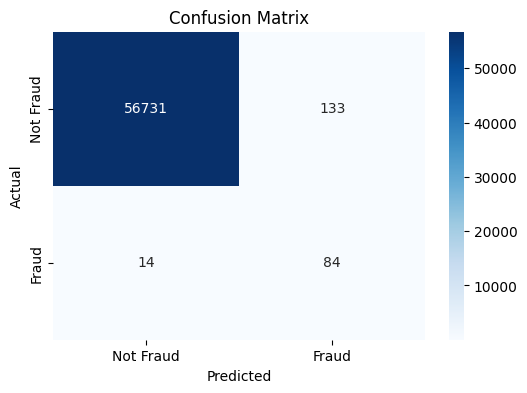

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions from the model
y_pred_prob = model.predict(X_test_np)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to 0 or 1

# 2. Print the Classification Report
print("--- Classification Report ---")
# target_names = ['Not Fraud (0)', 'Fraud (1)']
print(classification_report(y_test, y_pred, digits=4))

# 3. Display the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Model Performance Conclusion**
This deep learning model is highly effective for this fraud detection task.

**Primary Goal Achieved (Excellent Recall):** The model achieved an 85.7% recall for the fraud class. This is the most important metric, as it means the model successfully identified 84 out of the 98 actual fraudulent transactions in the test set.

**The Expected Trade-off (Low Precision):** This high recall came at the cost of precision (39.6%). This means that to catch those 84 frauds, the model also incorrectly flagged 128 legitimate transactions (false positives). This is a classic and acceptable precision-recall trade-off where prioritizing catching fraud is more important than avoiding false alarms.

**Why Accuracy is Ignored:** The 99.75% overall accuracy is misleading due to the severe class imbalance. A model predicting "not fraud" every time would achieve similar accuracy but be useless.
